In [2]:
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from datasets import load_dataset
from transformers import DataCollatorWithPadding
from transformers import BertModel
from transformers import AutoTokenizer
from torchmetrics import HingeLoss

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve, auc

from IPython.display import clear_output
import tqdm.notebook as tq

import time
import random

import sys
sys.path.append("../")
from src.utils import predict_with_model, pr_auc_macro
from src.model import BertSiameseModel

In [3]:
SEED = 2023
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Train tokenization

Загрузка ранее предобработанного датасета и создание DataLoader для тренировочной и тестовой выборки:

In [ ]:
data = load_dataset("parquet", data_files="../preprocessed/train_pairs_sampled_preprocessed.parquet", split='train')
text_data = data.train_test_split(test_size=0.1)

In [ ]:
bert_tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2", truncation=True, return_tensors='pt', model_max_length=256 )

text_data_1 = text_data['train'].map(lambda x : bert_tokenizer(x['attr_keys1'], x['attr_vals1'], truncation=True))
text_data_2 = text_data['train'].map(lambda x : bert_tokenizer(x['attr_keys2'], x['attr_vals2'], truncation=True))

text_data_val_1 = text_data['test'].map(lambda x : bert_tokenizer(x['attr_keys1'], x['attr_vals1'], truncation=True))
text_data_val_2 = text_data['test'].map(lambda x : bert_tokenizer(x['attr_keys2'], x['attr_vals2'], truncation=True))

In [7]:
rm_1 = ['variantid1', 'variantid2', 'categories1', 'categories2', 'attr_keys1', 'attr_keys2', 'attr_vals1', 'attr_vals2', 'name_bert_642']
rm_2 = ['variantid1', 'variantid2', 'categories1', 'categories2', 'attr_keys1', 'attr_keys2', 'attr_vals1', 'attr_vals2', 'name_bert_641']
text_data_1 = text_data_1.remove_columns(rm_1)
text_data_1 = text_data_1.rename_column("target", "labels")

text_data_2 = text_data_2.remove_columns(rm_2)
text_data_2 = text_data_2.rename_column("target", "labels")

text_data_val_1 = text_data_val_1.remove_columns(rm_1)
text_data_val_1 = text_data_val_1.rename_column("target", "labels")

text_data_val_2 = text_data_val_2.remove_columns(rm_2)
text_data_val_2 = text_data_val_2.rename_column("target", "labels")

In [8]:
text_data_val_1 = text_data_val_1.rename_column("name_bert_641", "name_bert")
text_data_1 = text_data_1.rename_column("name_bert_641", "name_bert")

text_data_val_2 = text_data_val_2.rename_column("name_bert_642", "name_bert")
text_data_2 = text_data_2.rename_column("name_bert_642", "name_bert")

In [9]:
data_collator = DataCollatorWithPadding(bert_tokenizer)
text_dataloader = DataLoader(text_data_1, batch_size=32, collate_fn=data_collator)
text_dataloader2 = DataLoader(text_data_2, batch_size=32, collate_fn=data_collator)

text_dataloader_val = DataLoader(text_data_val_1, batch_size=32, collate_fn=data_collator)
text_dataloader_val2 = DataLoader(text_data_val_2, batch_size=32, collate_fn=data_collator)

# Train

Загрузка модели:

In [6]:

rubert = BertModel.from_pretrained("cointegrated/rubert-tiny2")

device = "cuda:0" if torch.cuda.is_available() else 'cpu'
siam = BertSiameseModel(rubert)
siam = siam.to(device)

for param in siam.bert.parameters():
    param.requires_grad = False


for param in siam.bert.encoder.layer[2].parameters():
    param.requires_grad = True
for param in siam.bert.pooler.parameters():
    param.requires_grad = True
    
criterion = HingeLoss(task="binary").to(device)
optimizer = optim.SGD(siam.parameters(), lr=0.001)
history = []
history_val = []

Some weights of the model checkpoint at cointegrated/rubert-tiny2 were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Тренировка модели:

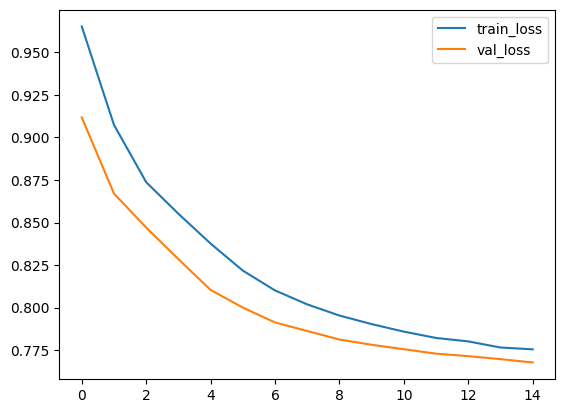

Epoch train loss: 0.7755467891693115

Epoch val loss: 0.7678244709968567



In [15]:
clear_output(True)
try:
    for epoch_n in tq.tqdm(range(15)):

        siam.train()
        epoch_losses = []
        for batch, batch2 in tq.tqdm(zip(text_dataloader, text_dataloader2), total=len(text_dataloader)):
            labels = batch['labels'].to(device)

            input_ids = batch['input_ids'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            bert_name = batch['name_bert'].to(device)

            input_ids2 = batch2['input_ids'].to(device)
            token_type_ids2 = batch2['token_type_ids'].to(device)
            bert_name2 = batch2['name_bert'].to(device)


            out = siam(ids_1=input_ids, type_ids_1=token_type_ids,ids_2=input_ids2, type_ids_2=token_type_ids2, name_1=bert_name, name_2=bert_name2)
            loss = criterion(out, labels.long())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_value = loss.cpu().data.numpy()
            epoch_losses.append(loss_value)

        epoch_loss = np.mean(epoch_losses)
        history.append(epoch_loss)


        siam.eval()
        epoch_val_losses = []
        for batch, batch2 in tq.tqdm(zip(text_dataloader_val, text_dataloader_val2), total=len(text_dataloader_val)):
            with torch.no_grad():
                labels = batch['labels'].to(device)

                input_ids = batch['input_ids'].to(device)
                token_type_ids = batch['token_type_ids'].to(device)
                bert_name = batch['name_bert'].to(device)

                input_ids2 = batch2['input_ids'].to(device)
                token_type_ids2 = batch2['token_type_ids'].to(device)
                bert_name2 = batch2['name_bert'].to(device)

                out = siam(ids_1=input_ids, type_ids_1=token_type_ids,ids_2=input_ids2, type_ids_2=token_type_ids2, name_1=bert_name, name_2=bert_name2)
                loss = criterion(out, labels.long())
                loss_val = loss.cpu().data.numpy()
                epoch_val_losses.append(loss_val)

        epoch_val_loss = np.mean(epoch_val_losses)
        history_val.append(epoch_val_loss)

        clear_output(True)  
        plt.plot(history, label='train_loss')
        plt.plot(history_val, label="val_loss")
        plt.legend()
        plt.show()
        print(f"Epoch train loss: {epoch_loss}\n")
        print(f"Epoch val loss: {epoch_val_loss}\n")
except KeyboardInterrupt:
    print("Stopped by user!")

In [17]:
torch.save(siam, f"/content/drive/MyDrive/hackathon_files_for_participants_ozon/models/{time.time()}.pth")

Валидация модели:

In [38]:
# SCORE VALIDATION
rm_cols = ['categories2', 'categories1', 'attr_keys1', 'attr_vals1', 'name_bert_641', 'attr_keys2', 'attr_vals2', 'name_bert_642']
rm_cols2 = ['categories2', 'attr_keys1', 'attr_vals1', 'name_bert_641', 'attr_keys2', 'attr_vals2', 'name_bert_642', 'target']

preds_val = predict_with_model(siam, text_dataloader_val, text_dataloader_val2, device)
y_val = text_data['test'].remove_columns(rm_cols).to_pandas()
X_val = text_data['test'].remove_columns(rm_cols2).to_pandas()
X_val['scores'] = preds_val
pr_auc_macro(target_df=y_val, predictions_df=X_val, cat_column='categories1')

0.3935945922317278

In [46]:
print(classification_report(y_val['target'], np.round(X_val['scores'], 0)))

              precision    recall  f1-score   support

         0.0       0.72      0.70      0.71      4361
         1.0       0.73      0.74      0.73      4595

    accuracy                           0.72      8956
   macro avg       0.72      0.72      0.72      8956
weighted avg       0.72      0.72      0.72      8956

